In [1]:
import sys
import os
from google.colab import drive

drive.mount('/content/drive')
project_root = '/content/drive/MyDrive/PETNN'
sys.path.append(project_root)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

df = pd.read_csv("https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm2.csv")
df['date'] = pd.to_datetime(df['date'])

df['day_cos'] = np.cos((2 * np.pi * df['date'].dt.dayofweek) / 7)
df['day_sin'] = np.sin((2 * np.pi * df['date'].dt.dayofweek) / 7)
df['month_cos'] = np.cos((2 * np.pi * df['date'].dt.month) / 12)
df['month_sin'] = np.sin((2 * np.pi * df['date'].dt.month) / 12)

minutes_in_day = df['date'].dt.hour * 60 + df['date'].dt.minute
df['time_cos'] = np.cos(2 * np.pi * minutes_in_day / 1440)
df['time_sin'] = np.sin(2 * np.pi * minutes_in_day / 1440)

def process_feature(df, col_name, train_limit, window_size=336, use_abs=True, clip_threshold=None):

    if use_abs:
        series = df[col_name].abs()
    else:
        series = df[col_name].copy()

    roll = series.rolling(window=window_size)
    mean = roll.mean()
    std = roll.std()

    local_norm = (series - mean) / (std + 1)

    if clip_threshold is not None:
        local_norm = local_norm.clip(-clip_threshold, clip_threshold)

    arcsinh_val = np.arcsinh(local_norm)

    scaler = RobustScaler()
    train_values = arcsinh_val.iloc[:train_limit].dropna().values.reshape(-1, 1)

    scaler.fit(train_values)
    final_values = scaler.transform(arcsinh_val.values.reshape(-1, 1))

    new_col_name = f"{col_name}_final"
    df[new_col_name] = final_values.flatten()


    return df

n = len(df)
train_size = int(0.7 * n)
val_size = int(0.15 * n)

W_SIZE = 14 * 24

features_config = [("HULL", True, None),("LUFL", True, None),("LULL", True, 3.5),("MULL", True, None),("MUFL", False, None),("HUFL", False, None)]

for col_name, abs_val, clip_val in features_config:
    df = process_feature(df,col_name,train_limit=train_size,window_size=W_SIZE,
        use_abs=abs_val,clip_threshold=clip_val)

target_col = 'OT'
target_scaler = RobustScaler()

raw_target_train = df.iloc[:train_size][[target_col]]
target_scaler.fit(raw_target_train)

df['OT_scaled'] = target_scaler.transform(df[[target_col]])

feature_cols_final = [c for c in df.columns if "_final" in c] + \
                     ["day_cos", "day_sin", "month_sin", "month_cos", "time_cos", "time_sin"]

target_col_final = 'OT_scaled'

data_features = df[feature_cols_final].copy()
data_target = df[[target_col_final]].copy()

data_features.describe().loc[["mean", "std", "min", "max"]]

df_model = pd.concat([data_features , data_target ], axis = 1 )

df_model = df_model.dropna()

n_clean = len(df_model)
train_lim = int(0.7 * n_clean)
val_lim = int(0.15 * n_clean)

train_data = df_model.iloc[:train_lim].copy()
val_data = df_model.iloc[train_lim:train_lim + val_lim].copy()
test_data = df_model.iloc[train_lim + val_lim:].copy()

train_scaled = train_data.values
val_scaled = val_data.values
test_scaled = test_data.values


## 🚀 **PETNN Architecture: Encoder Pre training**

This implementation of the **PETNN** employs an **Encoder Decoder** structure.

### **Patch Data**

This approach, inspired by PatchTST, transforms the input time series into overlapping patches (subsequences of 6 values) processed by a Conv1D layer. The primary goal was to mitigate the slow training inherent in the previous recurrent architecture. This patching successfully reduced the time per epoch by a factor of 3, enabling faster model development and training.


### **Role of the Encoder**

The primary job of the encoder is to generate an enriched representation of the input sequence. This representation serves as a powerful context for the decoder, enabling it to make high quality predictions in the downstream forecasting task.

### **Encoder Pre training Strategy**

To effectively initialize the encoder, we are using a Self Supervised Learning  method.  Specifically, the model will be trained to predict masked portion within the input data. This allows the encoder to learn robust temporal dependencies and patterns without requiring labeled target data.

### **Final Architecture**

The pre trained encoder will be integrated into the final architecture alongside a decoder and an attention mechanism. The frozen, pre-trained encoder weights will be utilized via transfer learning to accelerate convergence and improve the performance of the full model.




In [ ]:
from src.models import PETNN_Masked_Encoder, LinearHead
from src.train_utils import one_epoch_masked_encoder,masked_mae_loss
from src.data_loaders import create_loaders_mae

drive_save_path = '/content/drive/MyDrive/PETNN/weights/best_model.pth'

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

results = []
patch_size = 6
encoder_input_size = 13

train, val, test = create_loaders_mae(train_scaled, val_scaled, test_scaled, seq_length=96, patch_size=6, num_masked_patches=3, batch_size=64, num_workers=2)
criterion = lambda pred, target, mask: masked_mae_loss(pred, target, mask, patch_size, device)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = PETNN_Masked_Encoder(input_size=13 + 1, patch_size=6, stride=6,hidden_size=64, hard_switch=True,Rt_bias=2.5, dropout=0.05).to(device)
decoder = LinearHead(hidden_size=64, num_features=13, patch_size=6).to(device)

optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()),lr=0.001,weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode='min',factor=0.5,patience=3,min_lr=1e-6)

best_val_loss = float('inf')
best_model_path = 'best_model.pth'
skipped = False

num_epochs = 50

for epoch_num in range(num_epochs):
    train_loss, val_loss, avg_releases = one_epoch_masked_encoder(encoder, decoder, train, val, optimizer, device, patch_size=6, criterion=criterion)
    scheduler.step(val_loss)

    print(f"Epoch {epoch_num+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        checkpoint = {'epoch': epoch_num,'encoder_state_dict': encoder.state_dict(),'decoder_state_dict': decoder.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),'scheduler_state_dict': scheduler.state_dict(),'val_loss': val_loss,'train_loss': train_loss}

        torch.save(checkpoint, best_model_path)
        torch.save(checkpoint, drive_save_path)

        print(f"Best model saved with val_loss={val_loss:.6f}")


Epoch 1/50 - Train Loss: 0.322424, Val Loss: 0.264997
Best model saved with val_loss=0.264997
Epoch 2/50 - Train Loss: 0.241588, Val Loss: 0.237502
Best model saved with val_loss=0.237502
Epoch 3/50 - Train Loss: 0.229336, Val Loss: 0.225524
Best model saved with val_loss=0.225524
Epoch 4/50 - Train Loss: 0.225159, Val Loss: 0.227807
Epoch 5/50 - Train Loss: 0.223005, Val Loss: 0.219605
Best model saved with val_loss=0.219605
Epoch 6/50 - Train Loss: 0.221239, Val Loss: 0.219016
Best model saved with val_loss=0.219016
Epoch 7/50 - Train Loss: 0.220284, Val Loss: 0.218073
Best model saved with val_loss=0.218073
Epoch 8/50 - Train Loss: 0.219377, Val Loss: 0.217160
Best model saved with val_loss=0.217160
Epoch 9/50 - Train Loss: 0.218905, Val Loss: 0.220951
Epoch 10/50 - Train Loss: 0.218398, Val Loss: 0.218077
Epoch 11/50 - Train Loss: 0.217871, Val Loss: 0.214690
Best model saved with val_loss=0.214690
Epoch 12/50 - Train Loss: 0.217454, Val Loss: 0.215749
Epoch 13/50 - Train Loss: 0.2

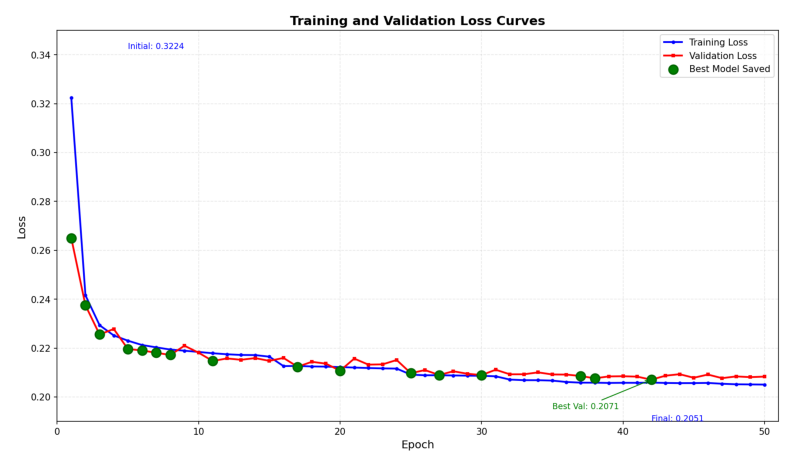

In [ ]:
import cv2
from matplotlib import pyplot as plt

img = cv2.imread('/content/drive/MyDrive/PETNN/images/training_curve.png')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 8))
plt.imshow(img_rgb)
plt.axis('off')
plt.show()

# **Masked Encoder Pre training**

The masked encoder has completed its pre-training phase. Before proceeding to the forecasting task, the mask must be removed from the encoder's input. We will then freeze its weights to implement a transfer learning approach, utilizing the learned representations for the downstream task.

In [4]:
from src.models import PETNN_Encoder
from src.train_utils import transfer_weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
forecasting_encoder = PETNN_Encoder(input_size=13, hidden_size=64, patch_size=6, stride=6, T_init=1.0, hard_switch=True, Rt_bias=2.5, Zt_bias=1.0, dropout=0.3).to(device)

forecasting_encoder = transfer_weights('/content/drive/MyDrive/PETNN/weights/best_model.pth', forecasting_encoder, device)
for param in forecasting_encoder.parameters():
    param.requires_grad = False

In [9]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from src.data_loaders import create_loaders_direct
from src.train_utils import one_epoch_final
from src.models import PETNN_DirectHead

df_model = df_model.dropna()

n_clean = len(df_model)
train_lim = int(0.7 * n_clean)
val_lim = int(0.15 * n_clean)


train_data = df_model.iloc[:train_lim].copy()
val_data = df_model.iloc[train_lim:train_lim + val_lim].copy()
test_data = df_model.iloc[train_lim + val_lim:].copy()

train , val , test = create_loaders_direct(train_data, val_data, test_data, 96, 96, 'OT_scaled', batch_size=64, num_workers=2)
criterion = nn.L1Loss()

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder = PETNN_DirectHead(input_dim=1024,output_dim=1,forecast_horizon=96,dropout=0.1).to(device)
optimizer = torch.optim.Adam(decoder.parameters(),  lr=0.001,weight_decay=0.0005)

num_epochs = 4

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

for epoch_num in range(num_epochs):

    train_loss, val_loss, avg_releases = one_epoch_final(forecasting_encoder, decoder, train, val, optimizer, criterion, device)
    scheduler.step(val_loss)

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch_num+1}: Train={train_loss:.6f}, Val={val_loss:.6f}, Avg Releases={avg_releases:.2f}")

Epoch 1: Train=0.159937, Val=0.168115, Avg Releases=1001.51
Epoch 2: Train=0.144869, Val=0.166854, Avg Releases=1001.51
Epoch 3: Train=0.144729, Val=0.167973, Avg Releases=1001.51
Epoch 4: Train=0.144754, Val=0.153617, Avg Releases=1001.51


In [10]:
from src.train_utils import evaluate_encoder_decoder

results = evaluate_encoder_decoder(forecasting_encoder, decoder, test, target_scaler, device, criterion=criterion)

------------------------------
Evaluation Results:
Loss (Scaled): 0.175113
MSE (Real)   : 18.216413
RMSE (Real)  : 4.268069
MAE (Real)   : 3.131130
------------------------------


/content/drive/MyDrive/PETNN/src/train_utils.py:242: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


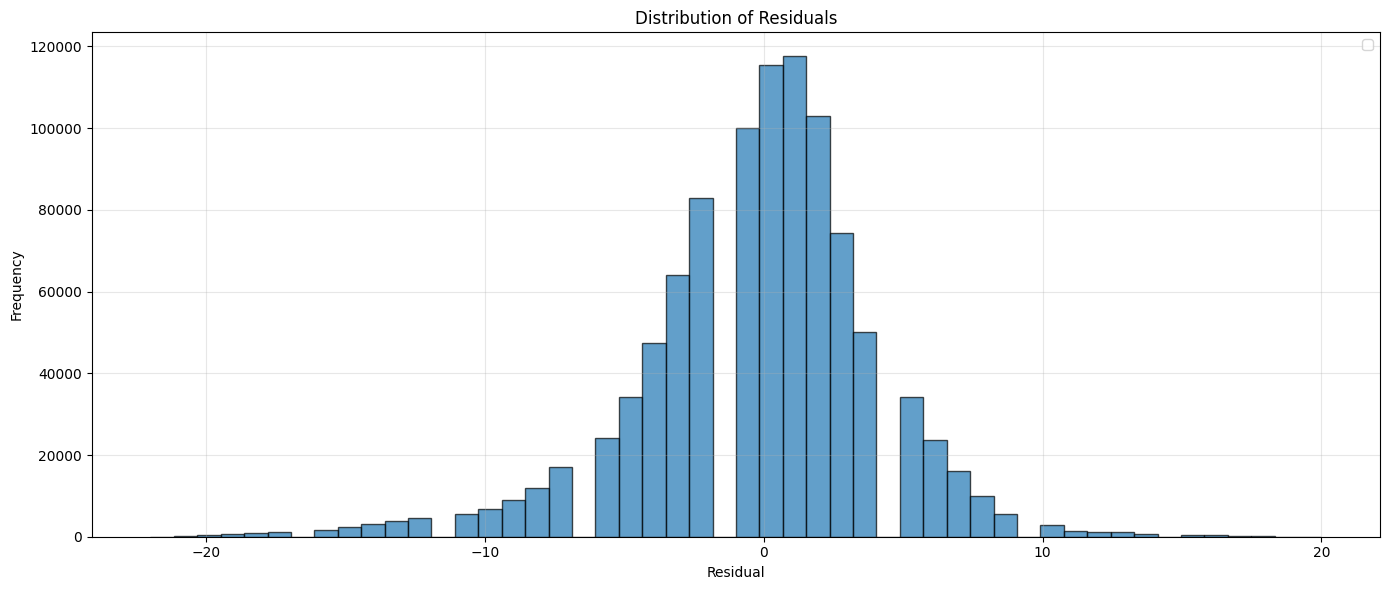

In [ ]:
from src.train_utils import plot_residuals_distribution

residuals = plot_residuals_distribution(results)

In [ ]:
residuals.mean()

np.float32(-0.25889435)


## **CONCLUSION**

The PETTN model with patching yielded good results, though data processing could be optimized. Adding **positional embeddings** would likely help the encoder handle sequences with consecutive masked values more effectively. We also recommend **fine-tuning** the encoder for forecasting to improve accuracy. Notably, the model exhibits no bias, with residuals consistently centered around zero.

